# Product Recommendation Systems

Context: Everyday a million products are being recommended to users based on
popularity and other metrics on e-commerce websites. The most popular e-commerce
website boosts average order value by 50%, increases revenues by 300%, and
improves conversion. In addition to being a powerful tool for increasing revenues,
product recommendations are so essential that customers now expect to see similar
features on all other eCommerce sites.

Source: Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The
repository has several datasets. For this case study, we are using the Electronics
dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('Electronic_dataset.csv')

In [3]:
df.sample(5)

,user_id,prod_id,ratings,timestamp
1493,A1SIYCMLNOBXYK,B002SNCQLI,4.0,1324598400
95648,A1C4MAZYFEMNOB,B005XLSZ44,2.0,1362960000
78166,A2KHR8EZ1F3JMX,B004VM1T5S,5.0,1365552000
60926,A2M7CYCDDC4UPK,B007R3Z44U,5.0,1403568000
259264,A2GFO9VPPAP7M4,B0002AHQLE,5.0,1162771200


In [4]:
df.drop('timestamp', axis=1, inplace=True)

In [5]:
df.shape

(500000, 3)

In [6]:
# Check for missing values 
df.isnull().sum()

user_id    0
prod_id    0
ratings    0
dtype: int64

In [7]:
# Number of unique products
df['prod_id'].nunique()

130138

In [8]:
# Number of unique users 
df['user_id'].nunique()

448368

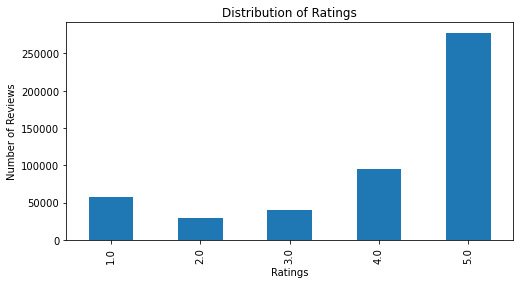

In [9]:
# plt.figure()
# plt.hist(mean_ratings, bins=[1, 2, 3, 4, 5])
_=plt.figure(figsize=(8,4))
_=df['ratings'].value_counts().sort_index().plot(kind='bar')
_=plt.title('Distribution of Ratings')
_=plt.xlabel('Ratings')
_=plt.ylabel('Number of Reviews')

* Most of the reviewers have rated products between 4 and 5 

In [10]:
ratings_by_product = pd.DataFrame(df.groupby('prod_id')['ratings'].count())

In [11]:
# Most popular products by number of ratings
pop_prods = ratings_by_product.sort_values(by='ratings',ascending=False) 
pop_prods.head(10)

,ratings
prod_id,
B0074BW614,1138
B00DR0PDNE,1094
B007WTAJTO,883
B0019EHU8G,774
B006GWO5WK,770
B003ELYQGG,765
B003ES5ZUU,681
B00622AG6S,668
B007R5YDYA,659


* These are the top 10 most popular products by number of ratings

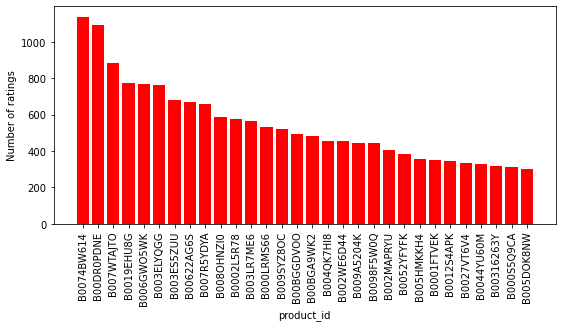

In [12]:
_=plt.figure(figsize=(9,4))
_=plt.bar(pop_prods.index[:30], pop_prods.ratings[:30], color='r')
_=plt.xticks(rotation=90)
_=plt.xlabel('product_id')
_=plt.ylabel('Number of ratings')

* This plot shows the 30 popular products by number of ratings. 
* Most popular products have over 1100 ratings 

In [13]:
mean_ratings_by_product = pd.DataFrame(df.groupby('prod_id')['ratings'].mean())
mean_ratings_by_product.columns = ['mean rating']
mean_ratings_by_product.head(5)

,mean rating
prod_id,
0439886341,1.0
0528881469,5.0
0594012015,5.0
0594033926,5.0
0594451647,5.0


In [14]:
mean_ratings_by_product.sort_values(by = 'mean rating',ascending=False).head(10)  

,mean rating
prod_id,
BT008G3W52,5.0
B003GRJTO2,5.0
B003GKTGYC,5.0
B003GM8VH8,5.0
B003GMATXW,5.0
B003GMBLZC,5.0
B003GMDHDG,5.0
B003GMGLFW,5.0
B003GMRUDY,5.0


* Top 10 products by mean ratings are all rated 5

## Popularity based recommendation model

In [15]:
top_ratings = pd.merge(ratings_by_product, mean_ratings_by_product, on='prod_id')

In [16]:
top_ratings['product'] = top_ratings['ratings'] * top_ratings['mean rating']

In [17]:
top_ratings['product'].sort_values(ascending=False).head(10)

prod_id
B0074BW614    5082.0
B00DR0PDNE    4314.0
B007WTAJTO    3901.0
B0019EHU8G    3669.0
B003ELYQGG    3356.0
B006GWO5WK    3292.0
B003ES5ZUU    3190.0
B007R5YDYA    3123.0
B00622AG6S    2952.0
B003LR7ME6    2555.0
Name: product, dtype: float64

* These are the top 10 product recommendations based on mean rating and total number of ratings

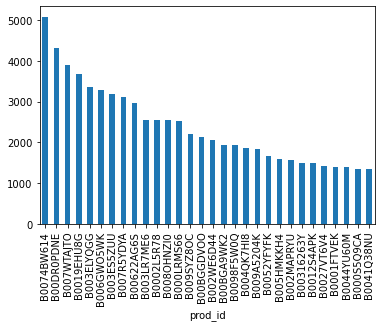

In [18]:
_=top_ratings['product'].sort_values(ascending=False).head(30).plot(kind='bar')

## 2. Collaborative filtering model

In [19]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD

In [20]:
# df_2 = df.sample(frac=0.1, replace=False, random_state=10) # taking ten percent of data due to insuffiecient memory

In [21]:
df_3 = df.groupby('user_id').filter(lambda x:  len(x)>=3) # considering only a subset of all ratings

In [22]:
df_3.shape

(30603, 3)

In [23]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [24]:
data = Dataset.load_from_df(df_3[['user_id', 'prod_id','ratings']], reader)

In [25]:
data

In [26]:
# train-test split
trainset, testset = train_test_split(data, test_size=.30,random_state=123)

#### 2.1 Support Vector Decomposition

In [27]:
svd_algo = SVD(n_factors=20)
svd_algo.fit(trainset)
svd_test_pred = svd_algo.test(testset)
# Then compute RMSE
accuracy.rmse(svd_test_pred)

RMSE: 1.1510


1.1510377208706646

In [28]:
svd_predictions = pd.DataFrame(svd_test_pred)

In [29]:
svd_predictions.head()

,uid,iid,r_ui,est,details
0,A1TLKLFUROWCJP,B003O8J1AU,5.0,4.177474,{'was_impossible': False}
1,A2NYK9KWFMJV4Y,B00JZC972Q,5.0,4.493107,{'was_impossible': False}
2,AY20S8XS9799P,B005HY4UPK,4.0,4.168247,{'was_impossible': False}
3,A3FMJFLC3S3LIH,B0029U2YSA,5.0,4.182765,{'was_impossible': False}
4,A1M85S3L9ROA17,B0026COIQ2,4.0,4.336508,{'was_impossible': False}


In [30]:
# df_3 = df_2[df_2["user_id"].isin(user_counts[counts > 5].index)]

#### 2.2 User based Collaborative Filtering

In [31]:
# Use user_based true/false to switch between user-based or item-based collaborat ive filtering
user_algo = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': True})
user_algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [32]:
# run the trained model against the testset
u_test_pred = user_algo.test(testset)

In [33]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(u_test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.2551


1.2550656977188583

#### 2.3 Item based Collaborative Filtering

In [34]:
item_algo = KNNWithMeans(k = 5, sim_option = {'user_based' : False})

In [35]:
item_algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [36]:
item_test_pred = item_algo.test(testset)

In [37]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(item_test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2551


1.2550656977188583

## Get top k recommendations

In [42]:
def recommend(usrId, num): # Based on SVD model 
    return svd_predictions[svd_predictions['uid'] == usrId][['uid','iid','r_ui','est']].sort_values(by='est', ascending=False).head(num)

In [44]:
recommend('A1EXGL6L0QQ0M5',3) # get top 3 recommendations for uid  

,uid,iid,r_ui,est
714,A1EXGL6L0QQ0M5,B001AQYJI2,4.0,4.297816
1687,A1EXGL6L0QQ0M5,B004SBBDB2,5.0,4.297816
7616,A1EXGL6L0QQ0M5,B00ATZJ60Q,4.0,4.297816


Insights

* In the popularity based recommendation model, the recommended products differ slightly when we take into 
account the number of ratings and mean ratings, as compared to considering number of ratings alone. 
* SVD gives the best performance in terms of RMSE as compared to Item based collaborative filtering and user based colaborative filtering.
* Since the ratings dataset was big and the sparse matrix generated was even bigger, only users who rated three or more products were considered for the collaborative filtering model.
* Popularity based model are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine.
* Model-based collaborative filtering system recommends items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.